In [1]:
from PIPELINES import retrieval
import pandas as pd
import ir_datasets
import matplotlib.pyplot as plt
import itertools
import collections
from nltk.corpus import stopwords

dataset = ir_datasets.load("beir/nfcorpus")
dataset_dev = ir_datasets.load("beir/nfcorpus/dev")
dataset_train = ir_datasets.load("beir/nfcorpus/train")
dataset_test = ir_datasets.load("beir/nfcorpus/test")

import warnings

# Ignorar todos os warnings
warnings.filterwarnings("ignore")

# Ignorar apenas warnings específicos
warnings.filterwarnings("ignore", category=UserWarning)


c:\Users\guiva\Documents\Aulas\Master\PRI\Search_Engine\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Criar mapeamento query -> Text -> DOCS

In [2]:
df_queries = pd.DataFrame(dataset.queries_iter())
df_qrels_dev = pd.DataFrame(dataset_dev.qrels_iter())
df_qrels_train = pd.DataFrame(dataset_train.qrels_iter())
df_qrels_test = pd.DataFrame(dataset_test.qrels_iter())
df_qrels = pd.concat([df_qrels_dev, df_qrels_train, df_qrels_test])

In [3]:
import pandas as pd

# Supondo que você já tenha os DataFrames df_qrels e df_queries
# df_qrels: colunas ['query_id', 'doc_id', 'relevance']
# df_queries: colunas ['querie_id', 'text']

# Crie um dicionário para mapear 'querie_id' ao texto correspondente
query_id_to_text = df_queries.set_index('query_id')['text'].to_dict()

# Filtre os documentos com relevance == 2 e agrupe por query_id
relevant_docs = (
    df_qrels[df_qrels['relevance'] == 2]
    .groupby('query_id')['doc_id']
    .apply(list)
    .to_dict()
)

# Crie um novo DataFrame consolidado por query_id
new_df = (
    df_qrels[['query_id']]
    .drop_duplicates()
    .set_index('query_id')
    .assign(
        query_text=lambda df: df.index.map(query_id_to_text),
        relevant_docs=lambda df: df.index.map(relevant_docs)
    )
    .reset_index()
)

# Preenchendo valores NaN em 'relevant_docs' com listas vazias
new_df['relevant_docs'] = new_df['relevant_docs'].apply(lambda x: x if x is not None else [])
new_df = new_df.dropna()
new_df=new_df[:500]
new_df.head()

,query_id,query_text,relevant_docs
0,PLAIN-1,Why Deep Fried Foods May Cause Cancer,"[MED-2421, MED-2422, MED-2416, MED-2423, MED-2..."
1,PLAIN-11,Living Longer by Reducing Leucine Intake,"[MED-2513, MED-2502, MED-2498, MED-2504, MED-2..."
2,PLAIN-22,Why are Cancer Rates so Low in India?,"[MED-2824, MED-2815, MED-2794, MED-2816]"
4,PLAIN-43,Organic Milk and Prostate Cancer,"[MED-2769, MED-2770, MED-2771, MED-2772, MED-2..."
5,PLAIN-55,Foods for Macular Degeneration,"[MED-2882, MED-2898, MED-2884, MED-2885, MED-2..."


In [4]:
# Lista para armazenar resultados de cada query
retrieval_results = {}

# Para cada query, executa o retrieval e armazena os resultados
for query in new_df['query_text']:
    results = retrieval(query)  # Chamada à função de retrieval
    retrieval_results[query] = results


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.43it/s]


In [5]:
import matplotlib.pyplot as plt


In [6]:
from collections import defaultdict

def aggregate_results(new_df, retrieval_results,store):
    # Agregar documentos relevantes e recuperados
    all_relevant_docs = set()
    all_retrieved_docs = []
    
    for relevant_docs in new_df['relevant_docs']:
        all_relevant_docs.update(relevant_docs)

    for query in new_df['query_text']:
        retrieved_docs = retrieval_results[query][store][store]  # Recupera top-k
        all_retrieved_docs.extend(retrieved_docs)
    
    return all_relevant_docs, all_retrieved_docs

# Calcula métricas globais
def calculate_global_metrics(all_relevant_docs, all_retrieved_docs,k):
    precisions, recalls = [], []
    
    # Precision-Recall por ponto
    relevant_found = 0
    for i, doc in enumerate(all_retrieved_docs):
        if doc['doc_id'] in all_relevant_docs:
            relevant_found += 1
        precisions.append(relevant_found / (i + 1))
        recalls.append(relevant_found / len(all_relevant_docs))
    
    # Precision@k global
    p_at_k = precisions[k-1] if len(precisions) >= k else precisions[-1]
    
    # MAP global
    map_score = sum(p for i, p in enumerate(precisions) if all_retrieved_docs[i]['doc_id'] in all_relevant_docs) / len(all_relevant_docs)
    
    return precisions, recalls, p_at_k, map_score


In [11]:
def plot_global_precision_recall(precisions, recalls):
    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, marker='o', label='Precision-Recall Curve (Global)', color='blue')
    plt.fill_between(recalls, precisions, alpha=0.1, color='blue')  # Área sob a curva
    plt.title("Global Precision-Recall Curve", fontsize=14)
    plt.xlabel("Recall", fontsize=12)
    plt.ylabel("Precision", fontsize=12)
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_global_metrics(p_at_k, map_score):
    metrics = {"P@10 (Global)": p_at_k, "MAP (Global)": map_score}
    plt.figure(figsize=(6, 4))
    plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'orange'])
    plt.title("Global Metrics", fontsize=14)
    plt.ylabel("Score", fontsize=12)
    plt.ylim(0, 1)
    for i, (metric, value) in enumerate(metrics.items()):
        plt.text(i, value + 0.02, f"{value:.3f}", ha='center', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


### Métricas VS

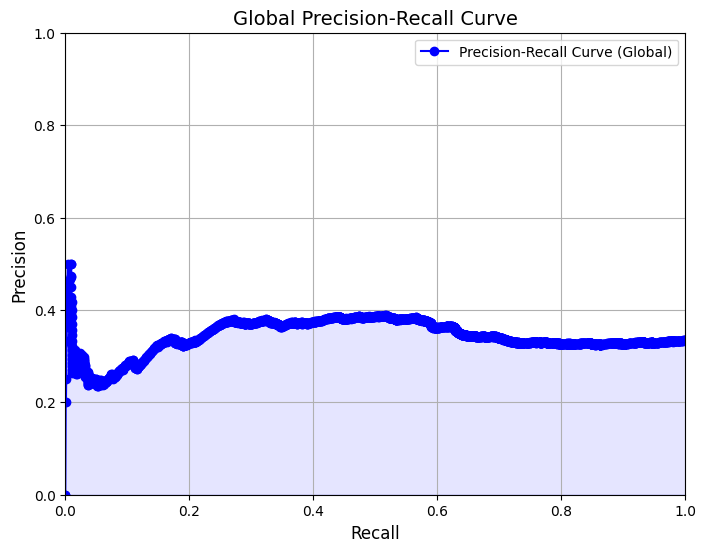

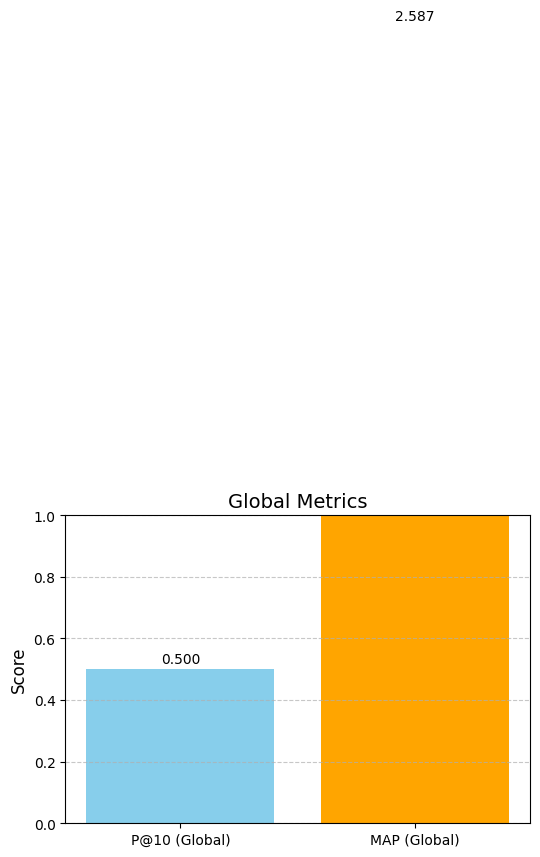

In [12]:
# Agregar resultados
all_relevant_docs, all_retrieved_docs = aggregate_results(new_df, retrieval_results,"VS")

# Calcular métricas globais
precisions, recalls, p_at_k, map_score = calculate_global_metrics(all_relevant_docs, all_retrieved_docs,8)

# Plotar curva Precision-Recall global
plot_global_precision_recall(precisions, recalls)

# Plotar métricas globais (P@10, MAP)
plot_global_metrics(p_at_k, map_score)


### Métricas KW

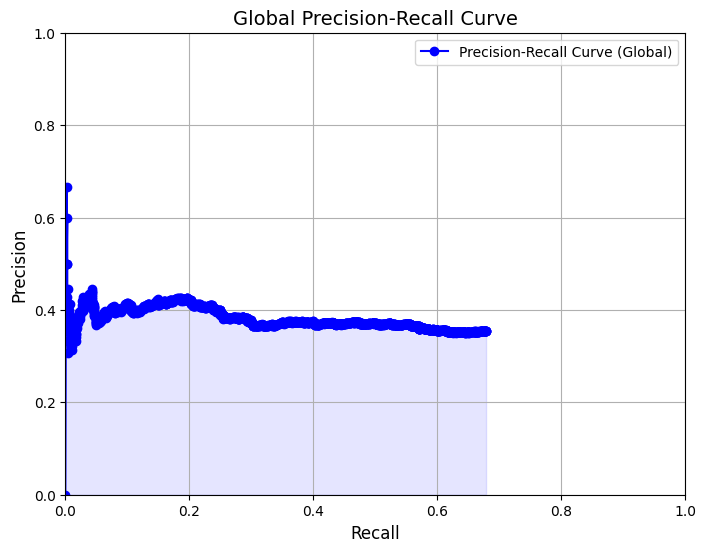

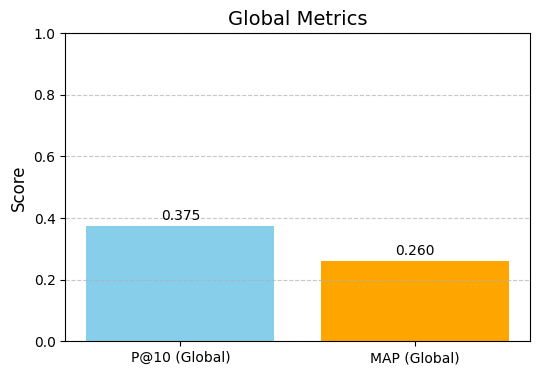

In [13]:
# Agregar resultados
all_relevant_docs, all_retrieved_docs = aggregate_results(new_df, retrieval_results,"KW")

# Calcular métricas globais
precisions, recalls, p_at_k, map_score = calculate_global_metrics(all_relevant_docs, all_retrieved_docs,8)

# Plotar curva Precision-Recall global
plot_global_precision_recall(precisions, recalls)

# Plotar métricas globais (P@10, MAP)
plot_global_metrics(p_at_k, map_score)


In [14]:
from collections import defaultdict
import pandas as pd

# def aggregate_results_i(new_df, retrieval_results, top_k, store):
#     # Agregar documentos relevantes e recuperados
#     all_relevant_docs = set()
#     all_retrieved_docs = []
    
#     for relevant_docs in new_df['relevant_docs']:
#         all_relevant_docs.update(relevant_docs)

#     for query in new_df['query_text']:
#         try:
#             retrieved_docs = [doc['doc_id'] for doc in retrieval_results[query][store]['docs'][:top_k]]
#             all_retrieved_docs.extend(retrieved_docs)
#         except KeyError as e:
#             print(f"Erro ao acessar resultados para a query '{query}': {e}")
    
#     return all_relevant_docs, all_retrieved_docs

# Calcula métricas globais
def calculate_global_metrics_i(all_relevant_docs, all_retrieved_docs, k):
    precisions, recalls = [], []
    
    # Evitar divisão por zero
    if not all_relevant_docs:
        return [], [], 0, 0

    relevant_found = 0
    for i, doc in enumerate(all_retrieved_docs):
    
        if doc['doc_id'] in all_relevant_docs:
            relevant_found += 1
        precisions.append(relevant_found / (i + 1))
        recalls.append(relevant_found / len(all_relevant_docs))
    
    # Precision@k global
    if precisions:
        p_at_k = precisions[k-1] if k <= len(precisions) else precisions[-1]
    else:
        p_at_k = 0
    
    # MAP global
    if all_relevant_docs:
        map_score = sum(p for i, p in enumerate(precisions) if all_retrieved_docs[i]['doc_id'] in all_relevant_docs) / len(all_relevant_docs)
    else:
        map_score = 0
    
    return precisions, recalls, p_at_k, map_score

query_metrics = []

for _, row in new_df.iterrows():
    query_id = row['query_id']
    relevant_docs = set(row['relevant_docs'])
    try:
        retrieved_docs = [doc for doc in retrieval_results[row['query_text']]['VS']['VS']]
    except KeyError as e:
        print(f"Erro ao acessar documentos para a query '{row['query_text']}': {e}")
        retrieved_docs = []
    # Calcula métricas para essa query
    precisions, recalls, p_at_k, map_score = calculate_global_metrics_i(
        relevant_docs,
        retrieved_docs,
        k=30    )
    
    query_metrics.append({
        'query_id': query_id,
        'map': map_score,
    })

df_metrics = pd.DataFrame(query_metrics)
global_map = df_metrics['map'].mean()

print(f"MAP geral: {global_map}")



MAP geral: 0.7554881454450096
